# Stage 09 - Feature Engineering

In the lecture, we learned how to create engineered features. Now it’s your turn to apply those ideas to your own project data.

In [1]:
import pandas as pd
import numpy as np
import sys

# Load the dataset
df = pd.read_csv('data/VIX_options_raw.csv')
df.head()

,Date,VIX_Close,Ticker,Industry,Underlying_Price,OptionType,Expiration,DTE,Strike,Last,Bid,Ask,Volume
0,2024-08-26,17.97,AAPL,Information Technology,183.69,Call,2024-09-25,30,174.5,11.14,10.37,11.90,277
1,2024-08-26,17.97,AAPL,Information Technology,183.69,Put,2024-09-25,30,174.5,1.52,1.41,1.62,362
2,2024-08-26,17.97,AAPL,Information Technology,183.69,Call,2024-09-25,30,193.0,1.89,1.76,2.02,47
3,2024-08-26,17.97,AAPL,Information Technology,183.69,Put,2024-09-25,30,193.0,10.73,9.99,11.46,179
4,2024-08-26,17.97,MSFT,Information Technology,432.57,Call,2024-09-25,30,411.0,30.55,27.78,33.33,651


## Part 1 - Implement Engineered Features

In [2]:
# Feature 1: Log-moneyness
df['log_moneyness'] = np.log(df['Underlying_Price'] / df['Strike'])

### Rationale for Feature 1

Log-moneyness is defined as $\ln\left(\frac{S}{K}\right)$, where $S$ is the price of the underlying asset and $K$ is the strike price. Log-moneyness is a simple measure of the relative strike price that is commonly used to make predictive inference of the options prices. 

In [3]:
# Feature 2: Year to Expiry
df['YTE'] = df['DTE'] / 365.25

### Rationale for Feature 2

For simplicity, we want to annualize and standardize the time to expiry so that it follows the tradition of measurement in years. We use the standard 365.25 days as the scale to adjust the time to expiry to years. 

In [4]:
# Feature 3: Bid-Ask Spread
df['Spread'] = df['Ask'] - df['Bid']

### Rationale for Feature 3

The bid–ask spread is the gap between buyers’ willingness to pay and sellers’ willingness to sell. It signals market quality: a tight spread usually implies liquid and competitive markets, while a wide spread usually implies lack of liquidity, higher volatility, or uncertainty about the true value of the asset.

In [5]:
# Feature 4: In-The-Money
df['ITM'] = (
    ((df['OptionType'].str.lower() == 'call') & (df['Underlying_Price'] > df['Strike'])) |
    ((df['OptionType'].str.lower() == 'put') & (df['Underlying_Price'] < df['Strike']))
).astype(int)

### Rationale for Feature 4

ITM is a dummy variable that returns 1 if the option has positive intrinsic value at the observation for calls when underlying price > strike and for puts when underlying price < strike and 0 otherwise. ITM serves as a simple moneyness indicator and often correlates with different liquidity indicators and pricing strategies.

## Part 2 - Save Featured Dataset

In [6]:
out_path = "data/VIX_options_features.csv"
df.to_csv(out_path, index = False)

df_features = pd.read_csv(out_path)
df_features.head()

,Date,VIX_Close,Ticker,Industry,Underlying_Price,OptionType,Expiration,DTE,Strike,Last,Bid,Ask,Volume,log_moneyness,YTE,Spread,ITM
0,2024-08-26,17.97,AAPL,Information Technology,183.69,Call,2024-09-25,30,174.5,11.14,10.37,11.90,277,0.051325,0.082136,1.53,1
1,2024-08-26,17.97,AAPL,Information Technology,183.69,Put,2024-09-25,30,174.5,1.52,1.41,1.62,362,0.051325,0.082136,0.21,0
2,2024-08-26,17.97,AAPL,Information Technology,183.69,Call,2024-09-25,30,193.0,1.89,1.76,2.02,47,-0.049441,0.082136,0.26,0
3,2024-08-26,17.97,AAPL,Information Technology,183.69,Put,2024-09-25,30,193.0,10.73,9.99,11.46,179,-0.049441,0.082136,1.47,1
4,2024-08-26,17.97,MSFT,Information Technology,432.57,Call,2024-09-25,30,411.0,30.55,27.78,33.33,651,0.051151,0.082136,5.55,1


## Part 3 - Correlation with Target

Treat `Last` (option price) as the target and compute correlations.

In [7]:
num_cols = df.select_dtypes(include = [np.number]).columns.tolist()
corr_series = df[num_cols].corr()['Last'].sort_values(ascending = False)
corr_series.to_frame('corr_with_Last').head(12)

,corr_with_Last
Last,1.000000
Ask,0.999895
Bid,0.999859
Spread,0.978416
Underlying_Price,0.654533
Strike,0.652096
ITM,0.585529
Volume,0.171484
VIX_Close,0.027668
log_moneyness,0.003143


## Part 4 - Plotting

Scatterplot of `Last` v.s. `VIX_Close` to visualize their relationship.

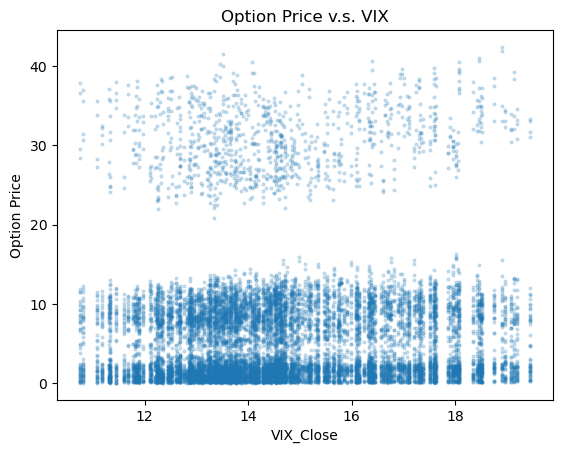

In [11]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(df['VIX_Close'], df['Last'], s = 4, alpha = 0.2)
plt.title('Option Price v.s. VIX')
plt.xlabel('VIX_Close')
plt.ylabel('Option Price')
plt.show()